In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from category_encoders import BinaryEncoder
from category_encoders import TargetEncoder


In [3]:
# 重新加载新上传的数据样本
df = pd.read_csv('data.csv')

# 特征选择
df.drop(columns=['street_name', 'listing_id', 'property_id', 'plan_no', 'extract_date', 'result_count', 'details_url', 'description', 'short_description', 'bullet_list', 'price_change', 'price_change_percent_list', 'price_change_date_list', 'price_change_direction_list', 'price_change_summary_percent', 'price_change_summary_direction', 'price_change_summary_last_updated_date', 'first_marketed_date', 'last_marketed_date', 'property_number', 'category', 'num_floors', 'displayable_address', 'agent_address', 'agent_postcode', 'agent_name', 'agent_logo', 'listing_status', 'status', 'branch_id', 'image_url', 'thumbnail_url', 'image_caption', 'original_image_list', 'other_image_list', 'other_image_desc_list', 'document_list', 'epc_list', 'virtual_tour_list', 'floor_plan_list'], inplace=True)
df.dropna(inplace=True)

# 数据清洗
df['ttwa11nm'] = df['ttwa11nm'].astype('category')
df['ttwa11cd'] = df['ttwa11cd'].astype('category')
df['outcode'] = df['outcode'].astype('category')
df['incode'] = df['incode'].astype('category')
df['property_type'] = df['property_type'].astype('category')
df['county'] = df['county'].astype('category')
df['country'] = df['country'].astype('category')
df['post_town'] = df['post_town'].astype('category')


In [4]:
num_features = ['num_bedrooms', 'num_bathrooms', 'num_recepts']
cate_features = ['ttwa11nm', 'outcode', 'incode', 'property_type', 'county', 'post_town']

# 1. 数值特征的异常值处理
for feature in ['num_bedrooms']:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 裁剪异常值
    df = df[(df[feature] <= upper_bound)]

# # 2. 类别特征的异常值处理
# for feature in cate_features:
#     # 计算每个类别的出现次数，并筛选出现次数超过1%的类别
#     counts = df[feature].value_counts()
#     threshold = 0.005 * len(df)
#     to_keep = counts[counts > threshold].index
#     df = df[df[feature].isin(to_keep)]

# 目标编码
encoder = TargetEncoder()
df[cate_features] = encoder.fit_transform(df[cate_features], df['price'])

df.shape


(8664, 12)

In [ ]:
# import pandas as pd

# # 加载数据
# df = pd.read_csv('data.csv')

# # 类别特征列表
# cate_features = ['ttwa11nm', 'ttwa11cd', 'outcode', 'incode', 'property_type', 'county', 'post_town']

# # 设置pandas的显示选项，以便完整显示所有数据
# pd.set_option('display.max_rows', None)  # 允许完全显示所有行
# pd.set_option('display.max_columns', None)  # 允许完全显示所有列
# pd.set_option('display.width', None)  # 自动调整显示宽度
# pd.set_option('display.max_colwidth', None)  # 允许列宽完全显示数据

# # 查看每个类别特征的类别样本数量占比
# for feature in cate_features:
#     print(f"类别分布比例 - {feature}:")
#     # 计算各类别的百分比
#     category_dist = df[feature].value_counts(normalize=True) * 100
#     # 打印结果
#     print(category_dist)
#     print("\n")  # 添加空行以便于阅读


In [5]:
# 重置原始 DataFrame 索引
df = df.reset_index(drop=True)

# 数据标准化
scaler = StandardScaler()
# encoder = OneHotEncoder()
encoder = OneHotEncoder(sparse_output=True)

# 对数值特征进行标准化
X_scaler = scaler.fit_transform(df[num_features+cate_features])
X_scaler = pd.DataFrame(X_scaler, columns=num_features+cate_features)

# # 对类别特征进行特征哈希
# fh = FeatureHasher(n_features=10, input_type='string')
# hashed_features = fh.fit_transform(df[cate_features].astype(str).values)
# hashed_features = pd.DataFrame(hashed_features.toarray())
# # 二进制编码
# encoder = BinaryEncoder(cols=cate_features)
# X_encoded = encoder.fit_transform(df[cate_features])


# 合并哈希后的特征和数值特征
# X_final = pd.concat([X_encoded, X_scaler], axis=1)
X_final = X_scaler

# 准备数据
X = X_final
y = df['price']

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 为固定效应添加常数项
exog = sm.add_constant(X_train)  # 添加常数项
endog = y_train
groups = df['county'][y_train.index]  # 用训练集的索引对应的county作为随机效应组

# 构建和拟合混合线性模型
model = MixedLM(endog, exog, groups=groups)
result = model.fit()

# 打印模型结果
result.summary()


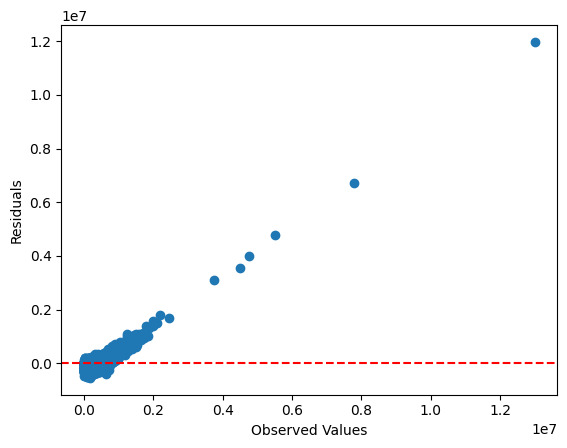

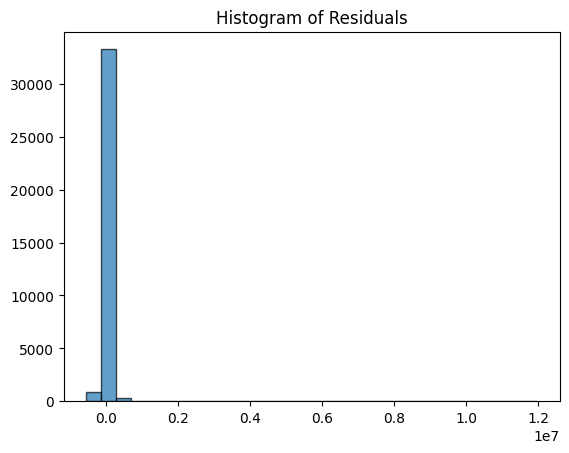

In [67]:
import matplotlib.pyplot as plt

# 拟合模型后计算残差
residuals = result.resid

# 可视化残差
plt.scatter(y_train, residuals)
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 检查残差的正态性
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.show()


In [68]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# 使用KFold或类似技术来保持随机效应结构
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = MixedLM(y_train, sm.add_constant(X_train), groups=df['county'][y_train.index])
    result = model.fit()
    predictions = result.predict(sm.add_constant(X_test))  # 预测测试集
    score = r2_score(y_test, predictions)  # 计算 R² 分数
    scores.append(score)

print("CV R² Scores: ", scores)


CV R² Scores:  [0.5475013477846673, 0.5617749123335998, 0.41579445023280137, 0.3090947126088698, 0.5154682710792247]
